Loading and preprocessing data...

Analyzing feature: age
Optimal threshold: 7.00
Training accuracy: 0.72
Testing accuracy: 0.64
AUC: 0.49

Confusion Matrix:
[[37  0]
 [21  0]]

Analyzing feature: menopause
Optimal threshold: 3.00
Training accuracy: 0.72
Testing accuracy: 0.64
AUC: 0.54

Confusion Matrix:
[[37  0]
 [21  0]]

Analyzing feature: tumor-size
Optimal threshold: 11.00
Training accuracy: 0.72
Testing accuracy: 0.64
AUC: 0.61

Confusion Matrix:
[[37  0]
 [21  0]]

Analyzing feature: inv-nodes
Optimal threshold: 1.00
Training accuracy: 0.74
Testing accuracy: 0.66
AUC: 0.60

Confusion Matrix:
[[31  6]
 [14  7]]

Analyzing feature: node-caps
Optimal threshold: 0.00
Training accuracy: 0.74
Testing accuracy: 0.67
AUC: 0.58

Confusion Matrix:
[[34  3]
 [16  5]]

Analyzing feature: deg-malig
Optimal threshold: 2.01
Training accuracy: 0.72
Testing accuracy: 0.72
AUC: 0.69

Confusion Matrix:
[[34  3]
 [13  8]]

Analyzing feature: breast
Optimal threshold: 1.00
Training accuracy: 0.72
T

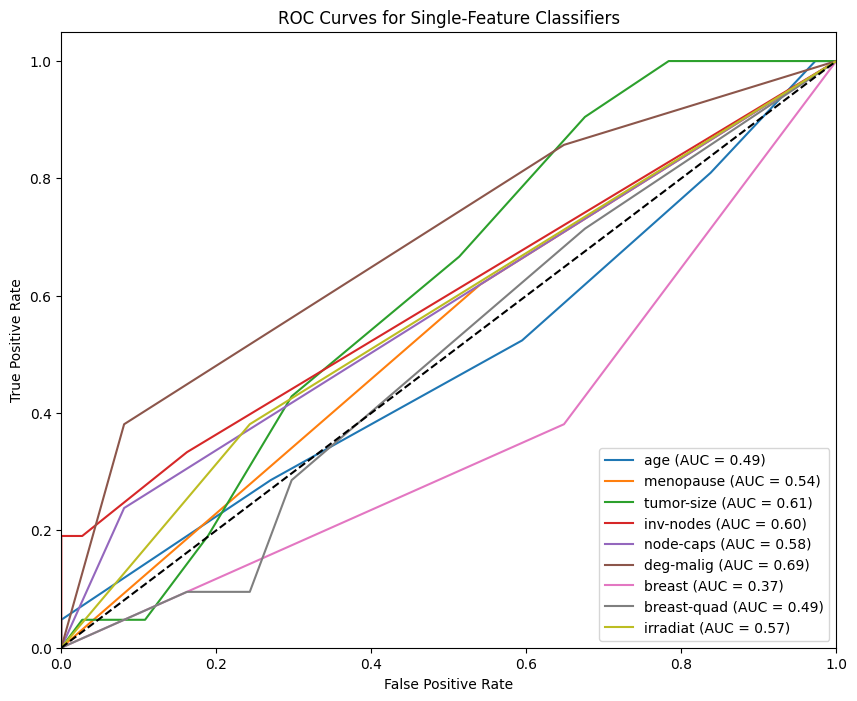

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc, confusion_matrix, classification_report
import matplotlib.pyplot as plt
from urllib.request import urlretrieve

def load_data():
    """
    Load and preprocess the breast cancer dataset
    """
    # Download and load the data
    url = "https://archive.ics.uci.edu/ml/machine-learning-databases/breast-cancer/breast-cancer.data"
    urlretrieve(url, "breast-cancer.data")

    # Define column names
    columns = [
        'Class',
        'age',
        'menopause',
        'tumor-size',
        'inv-nodes',
        'node-caps',
        'deg-malig',
        'breast',
        'breast-quad',
        'irradiat'
    ]

    # Load data
    data = pd.read_csv("breast-cancer.data", header=None, names=columns)

    # Convert class to numeric
    data['Class'] = (data['Class'] == 'recurrence-events').astype(int)

    # Convert categorical variables to numeric
    # Age groups
    age_map = {
        '10-19':1, '20-29':2, '30-39':3, '40-49':4,
        '50-59':5, '60-69':6, '70-79':7, '80-89':8, '90-99':9
    }
    data['age'] = data['age'].map(age_map)

    # Menopause
    menopause_map = {'lt40':1, 'ge40':2, 'premeno':3}
    data['menopause'] = data['menopause'].map(menopause_map)

    # Tumor size
    tumor_map = {
        '0-4':1, '5-9':2, '10-14':3, '15-19':4, '20-24':5,
        '25-29':6, '30-34':7, '35-39':8, '40-44':9, '45-49':10,
        '50-54':11, '55-59':12
    }
    data['tumor-size'] = data['tumor-size'].map(tumor_map)

    # Inv nodes
    nodes_map = {
        '0-2':1, '3-5':2, '6-8':3, '9-11':4, '12-14':5,
        '15-17':6, '18-20':7, '21-23':8, '24-26':9, '27-29':10,
        '30-32':11, '33-35':12, '36-39':13
    }
    data['inv-nodes'] = data['inv-nodes'].map(nodes_map)

    # Node caps
    data['node-caps'] = data['node-caps'].map({'yes':1, 'no':0})

    # Degree of malignancy is already numeric (1-3)

    # Breast
    data['breast'] = data['breast'].map({'left':0, 'right':1})

    # Breast quad
    quad_map = {
        'left_up':1, 'left_low':2, 'right_up':3,
        'right_low':4, 'central':5
    }
    data['breast-quad'] = data['breast-quad'].map(quad_map)

    # Irradiat
    data['irradiat'] = data['irradiat'].map({'yes':1, 'no':0})

    # Replace any remaining '?' with NaN and then with median of column
    for column in data.columns:
        data[column] = pd.to_numeric(data[column], errors='coerce')
        data[column] = data[column].fillna(data[column].median())

    return data

def single_feature_classifier(X_train, y_train, X_test, y_test, feature_name):
    """
    Build and evaluate a single feature classifier
    """
    # Find optimal decision boundary using training data
    thresholds = np.linspace(X_train.min(), X_train.max(), 100)
    best_accuracy = 0
    best_threshold = None

    for threshold in thresholds:
        predictions = (X_train > threshold).astype(int)
        accuracy = np.mean(predictions == y_train)

        if accuracy > best_accuracy:
            best_accuracy = accuracy
            best_threshold = threshold

    # Make predictions on test data
    test_predictions = (X_test > best_threshold).astype(int)
    test_accuracy = np.mean(test_predictions == y_test)

    # Calculate ROC curve and AUC
    fpr, tpr, _ = roc_curve(y_test, X_test)
    roc_auc = auc(fpr, tpr)

    # Calculate confusion matrix
    conf_matrix = confusion_matrix(y_test, test_predictions)

    return {
        'threshold': best_threshold,
        'train_accuracy': best_accuracy,
        'test_accuracy': test_accuracy,
        'fpr': fpr,
        'tpr': tpr,
        'auc': roc_auc,
        'confusion_matrix': conf_matrix,
        'feature_name': feature_name
    }

def plot_roc_curves(results):
    """
    Plot ROC curves for all features
    """
    plt.figure(figsize=(10, 8))
    for result in results:
        plt.plot(
            result['fpr'],
            result['tpr'],
            label=f"{result['feature_name']} (AUC = {result['auc']:.2f})"
        )

    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curves for Single-Feature Classifiers')
    plt.legend(loc="lower right")
    plt.show()

def main():
    # Load data
    print("Loading and preprocessing data...")
    data = load_data()

    # Split features and target
    X = data.drop('Class', axis=1)
    y = data['Class']

    # Split into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )

    # Analyze each feature
    results = []
    for feature in X.columns:
        print(f"\nAnalyzing feature: {feature}")
        result = single_feature_classifier(
            X_train[feature],
            y_train,
            X_test[feature],
            y_test,
            feature
        )
        results.append(result)

        print(f"Optimal threshold: {result['threshold']:.2f}")
        print(f"Training accuracy: {result['train_accuracy']:.2f}")
        print(f"Testing accuracy: {result['test_accuracy']:.2f}")
        print(f"AUC: {result['auc']:.2f}")
        print("\nConfusion Matrix:")
        print(result['confusion_matrix'])

    # Find best classifier
    best_result = max(results, key=lambda x: x['test_accuracy'])
    print("\nBest Classifier:")
    print(f"Feature: {best_result['feature_name']}")
    print(f"Testing accuracy: {best_result['test_accuracy']:.2f}")
    print(f"AUC: {best_result['auc']:.2f}")

    # Plot ROC curves
    plot_roc_curves(results)

if __name__ == "__main__":
    main()

In [7]:
from urllib.request import urlretrieve
import pandas as pd
import numpy as np
#testing to see how many cases of recurrence exist
def analyze_recurrence_distribution(file_path):
    """
    Analyze the distribution of recurrence vs no-recurrence cases in the breast cancer dataset.

    Parameters:
    -----------
    file_path : str
        Path to the breast cancer dataset file

    Returns:
    --------
    dict
        Dictionary containing counts and percentages for each class
    """
    # Read the data
    # The dataset uses '?' for missing values
    df = pd.read_csv(file_path, na_values='?', header=None, names=['Class','age','menopause','tumor-size','inv-nodes','node-caps','deg-malig','breast','breast-quad','irradiat'])

    # Get the class distribution
    class_counts = df['Class'].value_counts()
    total_cases = len(df)

    # Calculate percentages
    class_percentages = (class_counts / total_cases) * 100

    # Create summary dictionary
    summary = {
        'recurrence_count': int(class_counts.get('recurrence-events', 0)),
        'no_recurrence_count': int(class_counts.get('no-recurrence-events', 0)),
        'recurrence_percentage': float(class_percentages.get('recurrence-events', 0)),
        'no_recurrence_percentage': float(class_percentages.get('no-recurrence-events', 0)),
        'total_cases': total_cases
    }

    # Print summary
    print(f"\nBreast Cancer Dataset Analysis:")
    print(f"--------------------------------")
    print(f"Total number of cases: {total_cases}")
    print(f"Recurrence cases: {summary['recurrence_count']} ({summary['recurrence_percentage']:.1f}%)")
    print(f"No-recurrence cases: {summary['no_recurrence_count']} ({summary['no_recurrence_percentage']:.1f}%)")

    return summary

url = "https://archive.ics.uci.edu/ml/machine-learning-databases/breast-cancer/breast-cancer.data"
urlretrieve(url, "breast-cancer.data")

results = analyze_recurrence_distribution("breast-cancer.data")
print(results)


Breast Cancer Dataset Analysis:
--------------------------------
Total number of cases: 286
Recurrence cases: 85 (29.7%)
No-recurrence cases: 201 (70.3%)
{'recurrence_count': 85, 'no_recurrence_count': 201, 'recurrence_percentage': 29.72027972027972, 'no_recurrence_percentage': 70.27972027972028, 'total_cases': 286}
